In [ ]:
# High-level idea:
# input: a 3d-coordinate
# config/hyper-parameter: spacing res, transformation, scaling(10)
# function: 
# 1. localization the slice
# 2. tri-interpolation to get the scalar value
# 3. padding
# 4. simulation integration 

# TIPs: test your code all the time!!! Boundary Check.

# Observation:
# in blender: 3d model spans from 2.62m to 8.5m
# image resolution: 512 crop to 480 -->2.4 * 2 (positive and negative after scaling)
# Tri-interpolation lead to segmentation mistakes: voting?

In [1]:
import os
import sys
import numpy
import torch
import pydicom
import matplotlib.pyplot as plt

(512, 512)


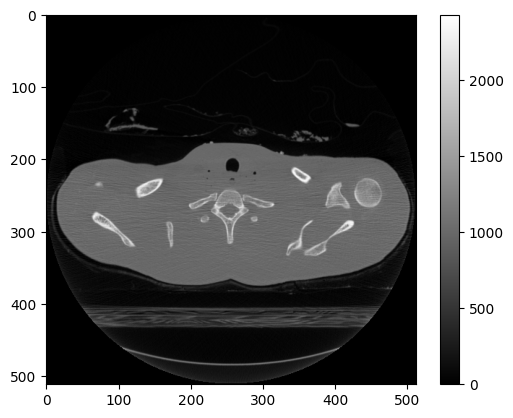

In [39]:
# data read
ct_path = "/home/zhenya/IDC/renamed/folder1"
dicom_data = pydicom.dcmread(os.path.join(ct_path,f"IM{560:06d}.dcm")) #0~588 instance: 850->262
print(dicom_data.pixel_array.shape)
plt.imshow(dicom_data.pixel_array,cmap='gray')
plt.colorbar()

def ct_read(idx:int, folder_path = "/home/zhenya/IDC/renamed/folder1"):
    return pydicom.dcmread(os.path.join(ct_path,f"IM{idx:06d}.dcm")).pixel_array

In [3]:
# Slice Localization: 3d coordinate --> instance number --> img number
locater_offset = -5
z = 2.78
# to instance number
num_insta  = (z-locater_offset)/0.01
# todo: upper bound, lower bound
num_img = 850 - int(num_insta)
retri_dicom = ct_read(num_img)
plt.imshow(retri_dicom.pixel_array,cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'pixel_array'

In [23]:
# Pixel Localization
xy = torch.tensor([0,0])
uv = (2.4 - xy)[torch.tensor([1,0])]/4.8 * 512
uv

tensor([256., 256.])

In [55]:
# trilinear_interpolation
pos = [0,2.78,0]
def localization(pos):
    locater_offset = -5
    z = pos[1]
    num_insta  = (z-locater_offset)/0.01
    z_offset = num_insta - int(num_insta)
    num_plane1 = 850 - int(num_insta)
    num_plane2 = 850 - (int(num_insta) + 1)
    plane1 = ct_read(num_plane1)
    plane2 = ct_read(num_plane2)

    xy = torch.tensor([pos[0], pos[2]])
    uv = ((2.4 - xy)[torch.tensor([1,0])]/4.8 * 512)

    return uv, plane1, plane2, z_offset

In [56]:
def tri_interpolation(uv:torch.Tensor, plane1, plane2, z_offset):
    base = uv.to(torch.int32)
    x_offset, y_offset = uv - base
    base = base.numpy()
    a, b, c, d = (1-x_offset)*(1-y_offset), x_offset*(1-y_offset), (1-x_offset)*y_offset, x_offset*y_offset
    e, f = 1 - z_offset, z_offset
    res  = a*e*plane1[base[0], base[1]] \
        + b*e*plane1[base[0]+1, base[1]]\
        + c*e*plane1[base[0], base[1]+1]\
        + d*e*plane1[base[0]+1, base[1]+1]\
        + a*f*plane2[base[0], base[1]]\
        + b*f*plane2[base[0]+1, base[1]]\
        + c*f*plane2[base[0], base[1]+1]\
        + d*f*plane2[base[0]+1, base[1]+1]
    return res

tri_interpolation(*localization(pos))

tensor(1527.)

## CT Retrival for Gaussian Splatting

In [2]:
sys.path.append(os.path.join('../'))
from scene import GaussianModel
gs_model = GaussianModel(sh_degree=3)
gs_model.load_ply('./point_cloud.ply')
xyz = gs_model.get_xyz

In [3]:
def read_volume(ct_path = "/home/zhenya/IDC/renamed/folder1"):
    volume = torch.zeros((589, 512, 512), dtype=torch.int32, device="cuda")
    for i in range(589):
        volume[i,:,:] = torch.tensor(pydicom.dcmread(os.path.join(ct_path,f"IM{i:06d}.dcm")).pixel_array)
    return volume

ct_volume = read_volume()

In [4]:
def ct_retrieval(pos: torch.Tensor, volume: torch.Tensor):
    def loc_tensor(pos: torch.Tensor):
        locater_offset = -5
        z = pos[:,1:2]
        num_insta  = (z-locater_offset)/0.01
        xy = pos[:, (0,2)]
        xy = ((2.4 - xy)[:, (1,0)]/4.8 * 512)
        xyz = torch.cat([xy, num_insta], dim=-1)
        return xyz
    pos = loc_tensor(pos)
    base = pos.to(torch.int64)
    offset = pos - base
    base[:,2] = 850 - base[:,2]
    x_offset, y_offset, z_offset = offset[:,0], offset[:,1], offset[:,2]
    a, b, c, d = (1-x_offset)*(1-y_offset), x_offset*(1-y_offset), (1-x_offset)*y_offset, x_offset*y_offset
    e, f = 1 - z_offset, z_offset
    res  = a * e * volume[base[:,2], base[:,0], base[:,1]] \
         + b * e * volume[base[:,2], base[:,0] + 1, base[:,1]]\
         + c * e * volume[base[:,2], base[:,0], base[:,1] + 1]\
         + d * e * volume[base[:,2], base[:,0] + 1, base[:,1] + 1]\
         + a * f * volume[base[:,2] + 1, base[:,0], base[:,1]]\
         + b * f * volume[base[:,2] + 1, base[:,0] + 1, base[:,1]]\
         + c * f * volume[base[:,2] + 1, base[:,0], base[:,1] + 1]\
         + d * f * volume[base[:,2] + 1, base[:,0] + 1, base[:,1] + 1]
    return res
    
# ct_retrieval(torch.tensor([[0,2.78,0]], device="cuda"), ct_volume) #for test
retrieved_ct_value = ct_retrieval(xyz, ct_volume)

## Analysis and Test

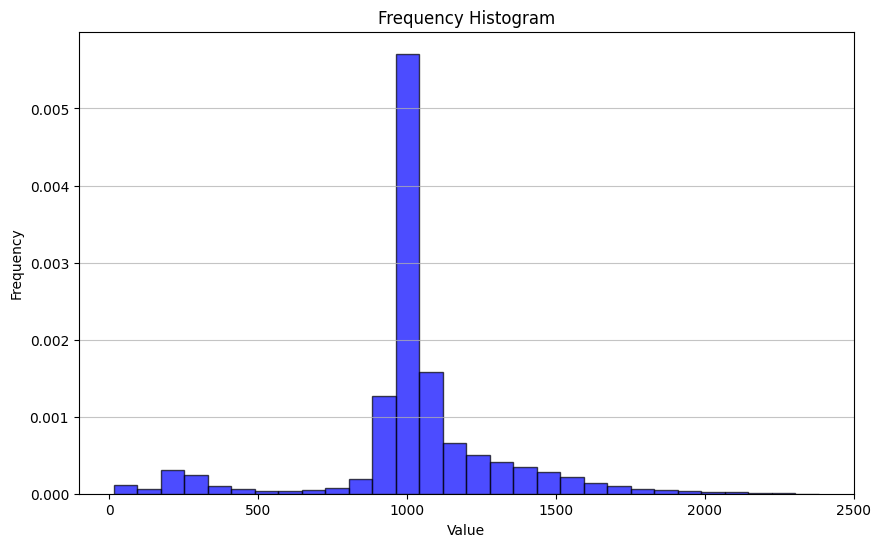

In [5]:
import numpy as np
import matplotlib.pyplot as plt

data = retrieved_ct_value.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')


plt.title('Frequency Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [38]:
import open3d as o3d
gs_model = GaussianModel(sh_degree=3)
gs_model.load_ply('./point_cloud.ply')
threshold = 900
prune_mask = retrieved_ct_value > threshold
gs_model.geometry_prune(prune_mask)
points_np = gs_model.get_xyz.detach().cpu().numpy()
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points_np)
o3d.visualization.draw_geometries([point_cloud], window_name='3D Point Cloud', width=800, height=600)